In [93]:
import pandas as pd
import geopandas as gpd
import pysal as psl
from shapely.geometry import Point
import xarray  # Surface data manipulation
from pysal.explore import esda  # Exploratory Spatial analytics
from pysal.lib import weights  # Spatial weights
import contextily  # Background tiles
from splot.esda import moran_scatterplot, plot_local_autocorrelation, lisa_cluster
from splot.libpysal import plot_spatial_weights
from esda.moran import Moran, Moran_Local
import numpy as np

In [9]:
pip install openpyxl -U

     -------------------------------------- 250.9/250.9 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.0.10
    Uninstalling openpyxl-3.0.10:
      Successfully uninstalled openpyxl-3.0.10
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
base = pd.read_excel(r'C:\Users\Lenovo\Downloads\Competição de Casos CAS + Swiss Re 2024 - CidadesTraduzidas (1).xlsx', skiprows = 3, sheet_name='Apólices e Eventos')
depara_loc = pd.read_excel(r'C:\Users\Lenovo\Downloads/Competição de Casos CAS + Swiss Re 2024 - CidadesTraduzidas (1).xlsx', sheet_name='Locais Segurados')

### Base de geometrias do mundo
base_geo_mundo = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27556\2947244480.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  base_geo_mundo = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [3]:
base = base.merge(depara_loc, left_on= 'ID', right_on='ID')

In [4]:
gdf = gpd.GeoDataFrame(base, geometry = [Point(xy) for xy in zip(base['Longitude'], base['Latitude'])])

In [71]:
w = weights.DistanceBand.from_dataframe(gdf, threshold= 30, binary = False)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\libpysal\weights\distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  W.__init__(


(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot: >)

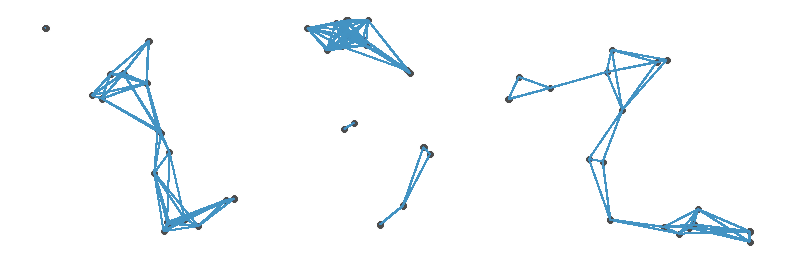

In [72]:
### Plot da vizinhança
plot_spatial_weights(w, gdf)

In [73]:
w.weights

{0: [4.354102493640594,
  4.354102493640594,
  4.354102493640594,
  4.354102493640594,
  4.354102493640594,
  4.354102493640594,
  4.354102493640594,
  4.354102493640594,
  4.354102493640594,
  4.354102493640594,
  9.640938086239423,
  9.640938086239423,
  9.640938086239423,
  9.640938086239423,
  9.640938086239423,
  9.640938086239423,
  9.640938086239423,
  9.640938086239423,
  9.640938086239423,
  9.640938086239423,
  0.08065150455820608,
  0.08065150455820608,
  0.08065150455820608,
  0.08065150455820608,
  0.08065150455820608,
  0.08065150455820608,
  0.08065150455820608,
  0.08065150455820608,
  0.08065150455820608,
  0.08065150455820608,
  0.08087039007006919,
  0.08087039007006919,
  0.08087039007006919,
  0.08087039007006919,
  0.08087039007006919,
  0.08087039007006919,
  0.08087039007006919,
  0.08087039007006919,
  0.08087039007006919,
  0.08087039007006919,
  11.523024038313702,
  11.523024038313702,
  11.523024038313702,
  11.523024038313702,
  11.523024038313702,
  11.52

In [81]:
moran = Moran(gdf['Valor do Sinistro'].fillna(0), w)
moran.I

### Valor próximo a zero indica que não há correlação entre o sinistro dos vizinhos

0.035492624235774664

In [82]:
moran.p_sim
#### H0: os valores são distribuídos aleatóriamente pelo espaço

0.001

(<Figure size 700x700 with 1 Axes>,
 <AxesSubplot: title={'center': 'Moran Scatterplot (0.04)'}, xlabel='Attribute', ylabel='Spatial Lag'>)

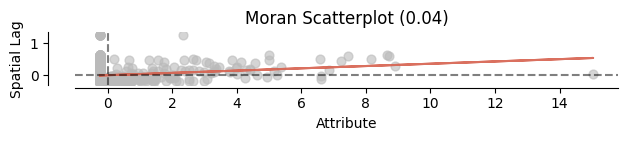

In [83]:
moran_scatterplot(moran)

Resultado da Autocorrelação Global: Existem clusters espaciais, mas há pouca correlação entre os pontos no espaço. Não foi possível auferir correlação espacial nas variáveis climáticas porque existem poucos dados.

Autocorrelação Local

In [84]:
moran_local = Moran_Local(gdf['Valor do Sinistro'], w)

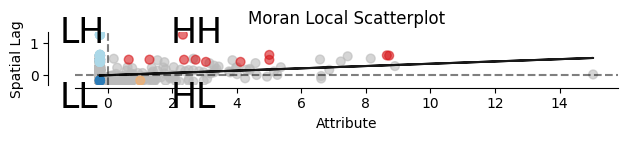

In [88]:

from matplotlib import pyplot as plt
# Plotting Local Moran's I scatterplot of pop_count
fig, ax = moran_scatterplot(moran_local, p=0.05);

plt.text(1.95, 1, 'HH', fontsize=25)
plt.text(1.95, -1.0, 'HL', fontsize=25)
plt.text(-1.5, 1, 'LH', fontsize=25)
plt.text(-1.5, -1, 'LL', fontsize=25)
plt.show()

In [90]:
gdf['cluster'] = moran_local.q

In [94]:
# Dict to map local moran's classification codes
local_moran_classification = {1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL'}

# Mapping local moran's classification codes
gdf['cluster'] = gdf['cluster'].map(local_moran_classification)

# p-value for each observation/neighbor pair
gdf['pvalor'] = moran_local.p_sim

# If p-value > 0.05 it is not statistical significant
gdf['cluster'] = np.where(gdf['pvalor'] > 0.05, 'ns', gdf['cluster'])

gdf.head()


ID  Ano da Apólice  Importância Segurada  Prêmio  ID Evento  Mês  \
0  loc001            2014              87223100  659145        NaN  NaN   
1  loc001            2015              89011170  672330        NaN  NaN   
2  loc001            2016              90444250  685780        NaN  NaN   
3  loc001            2017              92596820  699500        NaN  NaN   
4  loc001            2018              94439500  713490        NaN  NaN   

   Duração da Enchente (dias)  Severidade da Enchente (escala 1-5)  \
0                         NaN                                  NaN   
1                         NaN                                  NaN   
2                         NaN                                  NaN   
3                         NaN                                  NaN   
4                         NaN                                  NaN   

   Precipitação (mm)  Aumento do Nível da Água (m)  Valor do Sinistro  \
0                NaN                           NaN                  0   
1                NaN                           NaN                  0   
2                NaN                           NaN                  0   
3                NaN                           NaN                  0   
4                NaN                           NaN                  0   

   Latitude  Longitude          Cidade           País  \
0  -33.9069    18.4163  Cidade do Cabo  África do Sul   
1  -33.9069    18.4163  Cidade do Cabo  África do Sul   
2  -33.9069    18.4163  Cidade do Cabo  África do Sul   
3  -33.9069    18.4163  Cidade do Cabo  África do Sul   
4  -33.9069    18.4163  Cidade do Cabo  África do Sul   

                     geometry cluster  pvalor  
0  POINT (18.41630 -33.90690)      ns   0.231  
1  POINT (18.41630 -33.90690)      ns   0.231  
2  POINT (18.41630 -33.90690)      ns   0.231  
3  POINT (18.41630 -33.90690)      ns   0.231  
4  POINT (18.41630 -33.90690)      ns   0.231